##### algom/playbooks
# playbook_train

##### Asset price prediction using Scikit Learn regression models. Stores metadata related to the input data, model training, and evaluation.
<br>

#### Documentation: Random Forests
+ [sklearn documentation: Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
+ [Wikipedia: Random Forests](https://en.wikipedia.org/wiki/Random_forest)
+ [Towards Science: Random Forest](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)
+ [StackAbuse: Random Forest](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)
+ [Kaggle Random Forest](https://www.kaggle.com/nsrose7224/random-forest-regressor-accuracy-0-91). Test/plot different number of estimators. 


#### Documentation: Model Performance
+ [Scikit Learn: Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)
+ [Scikit Learn: R^2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)
+ [Medium: Choosing the Right Metric for Evaluating Machine Learning Models ](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4)
+ [Medium: How to evaluate regression models?](https://medium.com/acing-ai/how-to-evaluate-regression-models-d183b4f5853d)


#### Resources
+ [BigQuery](https://console.cloud.google.com/bigquery?folder=&organizationId=&project=algomosaic-nyc)
+ [Storage](https://console.cloud.google.com/storage/browser/algom-trading/models/?project=algomosaic-nyc)


#### Steps
1. Get data and initiate model
2. Train model
3. Evaluate model
4. Get model performance
5. Pickle and store model


<br> 

#### Requirements


In [3]:
import sys
sys.path.append('/home/jovyan/algom-trading/src')
from etl import ticker_etl
from model import model_mgmt as mm
from model import model_regression as mg



<br>

## 1. Extract indicators and features

In [4]:
# specify ticker and other parameters
etl_process = ticker_etl.etl(
    ticker='BTC-USD', 
    start_date='2010-07-01',
)

# specify packages to apply (optional)
etl_process.ohlc_library = 'etl.get_ticker_data'
etl_process.indicators_library = 'etl.get_indicators'
etl_process.features_library = 'etl.get_feature_engineering'

# get ticker indicators and features
df = etl_process.get_ticker_etl()

# load to bigquery and preview
etl_process.ticker_to_bigquery()
df.tail()


/home/jovyan/algom-trading/src/etl/talib_features.py:159: RuntimeWarning: divide by zero encountered in log
  np.log( df[numerator].shift(numerator_shift) / df[denominator].shift(denominator_shift) ),


RUNNING: algomosaic-nyc:yahoo_features.features_BTC_USD_20191015 is being extracted and transformed.


Enter the file path and name for GCP's Service Account credentials file.
            See for more details: https://console.cloud.google.com/iam-admin/serviceaccounts?project=<projectId> 

            The current directory is: /home/jovyan/algom-trading/notebooks/optimize.

             /home/jovyan/algom-trading/algomosaic-nyc.json


Loaded dataframe to BigQuery in 0:01:05.222962:	algomosaic-nyc:yahoo_features.features_BTC_USD_20191015
SUCCESS: algomosaic-nyc:yahoo_features.features_BTC_USD_20191015 has been loaded to BigQuery. Runtime: 0:01:12.612194.


,As_of_Date,Date,Ticker,Week,Month,Quarter,Year,Day_of_Week,Day_of_Year,High,...,RATIO_Close_5_Close_10,RATIO_Close_5_Close_15,RATIO_Close_5_Close_30,RATIO_Close_10_Close_15,RATIO_Close_10_Close_30,RATIO_Close_10_Close_60,RATIO_Close_10_Close_90,RATIO_Close_15_Close_30,RATIO_Close_15_Close_60,RATIO_Close_15_Close_90
3372,2019-10-15,2019-10-09,BTC-USD,41,10,4,2019,2,282,8672.580078,...,0.982905,0.967504,0.808399,0.984332,0.822459,0.719939,0.704786,0.835551,0.731399,0.716004
3373,2019-10-15,2019-10-10,BTC-USD,41,10,4,2019,3,283,8834.110352,...,0.944956,0.974405,0.774058,1.031164,0.819147,0.731215,0.732723,0.794391,0.709116,0.710578
3374,2019-10-15,2019-10-11,BTC-USD,41,10,4,2019,4,284,8439.440430,...,0.978978,1.001677,0.787721,1.023186,0.804636,0.771847,0.822342,0.786403,0.754356,0.803707
3375,2019-10-15,2019-10-12,BTC-USD,41,10,4,2019,5,285,8498.589844,...,0.993400,0.996136,0.789784,1.002754,0.795032,0.822009,0.760009,0.792848,0.819751,0.757922
3376,2019-10-15,2019-10-15,BTC-USD,42,10,4,2019,1,288,8439.309570,...,1.052046,1.065454,0.829011,1.012745,0.787999,0.792360,0.866780,0.778082,0.782389,0.855872


<br> 
## 2. Train model


In [6]:
# file = '../queries/SPY_n10/SPY_n10_testing.sql'
file = '../../queries/BTC/BTC_features_n10.sql'
attributes = {'partition': "20191011"}
data = mm.modelQuery(file=file, attributes=attributes)
model = mg.modelRegression(data, 'ROR_n10')


Writing query to a dataframe.
Loaded query to dataframe in 0:00:20.030918.


In [7]:
model.df.shape

(3010, 344)

<br>

### Train model

##### Add the dataframe and outcome to `modelRegression()` class.

`self.set_omits()`: specify any features to omit from the feature set, especially other outcome variables.

`self.model_description`: provide a string to provide more information related to this model execution.


In [8]:
# from sklearn.ensemble import RandomForestRegressor
# reg = RandomForestRegressor()

from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor(
    loss='ls', 
    learning_rate=0.1,
    n_estimators=800,
    subsample=.9,
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3,
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None, 
    random_state=None, 
    max_features=None, 
    alpha=0.9, 
    verbose=0,
    max_leaf_nodes=None, 
    warm_start=False, 
    presort='auto', 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001
)

model.set_omits(['ROR_n1', 'ROR_n3', 'ROR_n5', 'ROR_n10', 'ROR_n15', 'ROR_n20', 'ROR_n25', 'ROR_n30'])
model.model_description = "Predictions for BTC ROR_n10. GradientBoostingRegressor. IN DEVELOPMENT."
model.fit(reg)


Omit and features lists have been updated.
Training model on ROR_n10.
Model metadata added to `self.metadata.metadata`
Model metadata added to `self.metadata.parameters`
Set feature_importance to `self.feature_importance.feature_importance`
Fit model in 0:00:32.297969.


<br>

### Evaluate model and get performance
Get key performance metrics. 

In [9]:
model.evaluate()


Model metadata added to `self.metadata.metadata`
Model metadata added to `self.metadata.parameters`
Set evaluation to self.evaluations in 0:00:00.021440.


<br>

### Get model performance

+ Mean Absolute Error
+ Error Variance
+ R-Squared


In [11]:
model.get_performance()

#<<<<<<<<<<<<<<<< N10 >>>>>>>>>>>>>>>>>

# MODEL PERFORMANCE SUMMARY
#  - R-Squared:		 0.66065
#  - R-Squared:		 0.67821



Set R^2 to `self.rsquared`
The following performance measures have been added:
                - self.mean_abs_error
                - self.mean_abs_outcome
                - self.mean_abs_pct_error
                - self.error_var
            
Performance metrics added to `self.performance`

MODEL PERFORMANCE SUMMARY
        - Mean Absolute Error:	 0.05366
        - Mean Absolute Outcome:	 0.11997
        - Mean Absolute Percent Error:	 0.44727
        - Error Variance:	 0.01189
        - R-Squared:		 0.67178
        
PLOT PREDICTIONS: Use the following commands to view model performance.
        `self.plot_predictions_by_date(start_date, end_date)`
        `self.plot_predictions_histogram(start_date, end_date)`
        `self.plot_errors_by_date(start_date, end_date)`
        `self.plot_errors_histogram(start_date, end_date)`
        `self.plot_predictions_scatterplot(start_date, end_date)`
        


In [12]:
# list(model.df)
# model.outcome
model.metadata.model_execution_id


'f8455844179f7e5a2fced869d5013565a191bf98'

<br>

### Pickle and store model

In [13]:
import model.model_mgmt as mm
model.storage = mm.modelStorage(model)
model.storage.pickle_model(to_gcs=True)


Dumped model to:
	/home/jovyan/algom-trading/models/20191015_GradientBoostingRegressor_BTC-USD_f8455844179f7e5a2fced869d5013565a191bf98.pickle
Uploaded pickle to Google Storage:
	https://storage.googleapis.com/algom-trading/models/20191015_GradientBoostingRegressor_BTC-USD_f8455844179f7e5a2fced869d5013565a191bf98.pickle
Loaded dataframe to BigQuery in 0:00:06.501811:	algomosaic-nyc:yahoo_model_storage.model_storage_20191015
Loaded query to BigQuery in algomosaic-nyc.yahoo_model_storage.model_storage_20191015.
Dataset has been deduplicated: 	algomosaic-nyc.yahoo_model_storage.model_storage_20191015


<br>

### Load model results and metadata to BigQuery 


In [14]:
model.load_to_bq()


Loaded dataframe to BigQuery in 0:00:18.520520:	algomosaic-nyc:yahoo_model_metadata.model_queries_20191015
Loaded query to BigQuery in algomosaic-nyc.yahoo_model_metadata.model_queries_20191015.
Dataset has been deduplicated: 	algomosaic-nyc.yahoo_model_metadata.model_queries_20191015
yahoo_model_predictions.model_prediction_YYYYMMDD does not exist. Skipping.
Loaded dataframe to BigQuery in 0:00:06.758765:	algomosaic-nyc:yahoo_model_predictions.model_evaluation_20191015
Loaded query to BigQuery in algomosaic-nyc.yahoo_model_predictions.model_evaluation_20191015.
Dataset has been deduplicated: 	algomosaic-nyc.yahoo_model_predictions.model_evaluation_20191015
Loaded dataframe to BigQuery in 0:00:05.311331:	algomosaic-nyc:yahoo_model_performance.model_performance_20191015
Loaded query to BigQuery in algomosaic-nyc.yahoo_model_performance.model_performance_20191015.
Dataset has been deduplicated: 	algomosaic-nyc.yahoo_model_performance.model_performance_20191015
Loaded dataframe to BigQuer

<br>

### View performance 

+ Trending predictions vs outcomes
+ Histogram of predictions vs outcomes


PLOT: Predictions by Date
        `self.plot_predictions_by_date(start_date, end_date)`
        
PLOT: Prediction Errors by Date`
PLOT: Predictions Histogram
PLOT: Predictions Histogram
PLOT: Predictions by Date


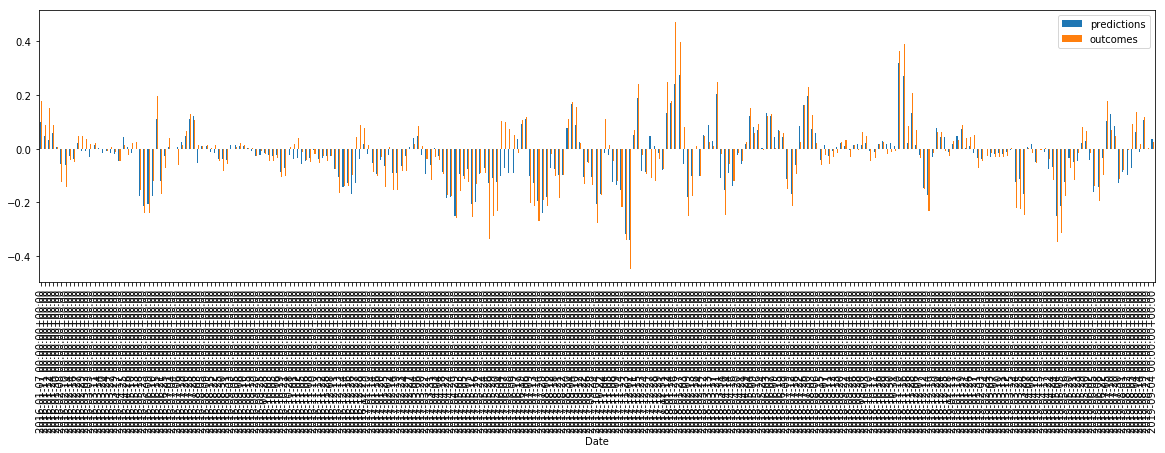

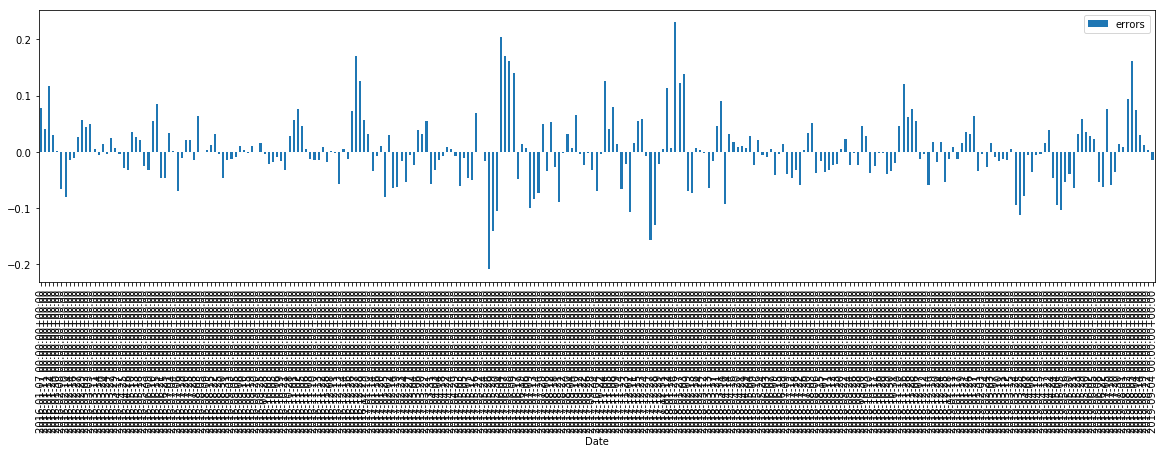

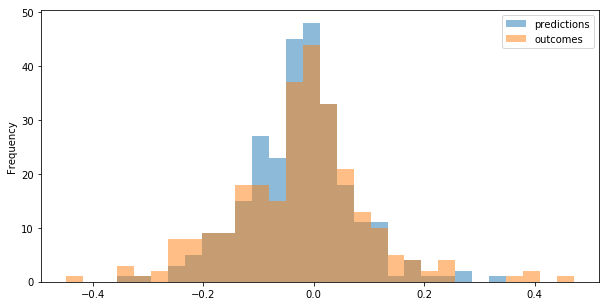

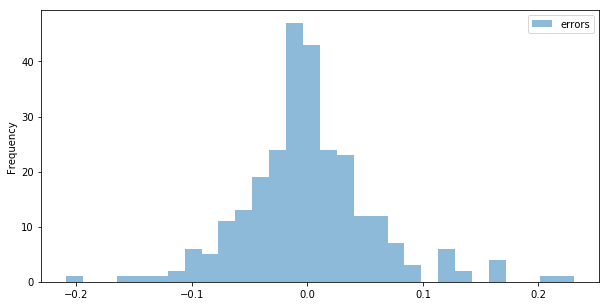

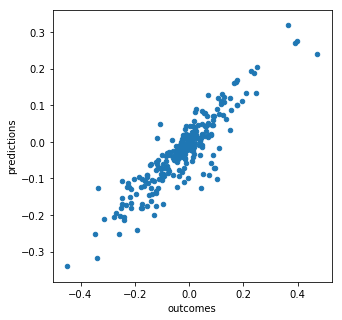

In [15]:
start_date='2016-01-01'
end_date='2020-01-01'
%matplotlib inline

model.plot_predictions_by_date(start_date, end_date)
model.plot_errors_by_date(start_date, end_date)
model.plot_predictions_histogram(start_date, end_date)
model.plot_errors_histogram(start_date, end_date)
model.plot_predictions_scatterplot(start_date, end_date)


In [16]:
features = model.feature_importance.feature_importance
features[0:50]


,model_execution_id,data_id,outcome_variable,variable,importance
0,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,RATIO_Low_2_Close_2,0.04495
1,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,AROR_180,0.03993
2,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,ATR_7,0.03144
3,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,ATR_150,0.02931
4,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,ATR_20,0.02559
5,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,ROR_LOG_MIN_10_MIN_20,0.02428
6,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,RATIO_High_Low,0.02298
7,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,DIFF_AROR_5_AROR_25,0.02256
8,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,ROR_LOG_EMA_25_EMA_50,0.02112
9,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,EMA_25,0.02070


In [17]:
features[len(features)-10:len(features)]

,model_execution_id,data_id,outcome_variable,variable,importance
317,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,Bollinger_pct_b_150,0.0
318,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,Bollinger_pct_b_5,0.0
319,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,EMA_150,0.0
320,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,EMA_200,0.0
321,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,MIN_9,0.0
322,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,RATIO_Close_3_Close_10,0.0
323,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,RATIO_Close_3_Close_15,0.0
324,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,RATIO_Close_Close_30,0.0
325,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,RATIO_High_3_Close_3,0.0
326,09dde877cfe528f240f9b89ab7716c6914425f50,dde63b7bd4bf300151bb9386582172b0099cf1fe,ROR_n10,ROR_LOG_EMA_10_EMA_100,0.0


<br>

### View trending features


PLOT: {} by Date
    To view over select time periods, run `plot_features_by_date(df, feature, start_date, end_date)`
    
PLOT: {} by Date
    To view over select time periods, run `plot_features_by_date(df, feature, start_date, end_date)`
    
PLOT: {} by Date
    To view over select time periods, run `plot_features_by_date(df, feature, start_date, end_date)`
    


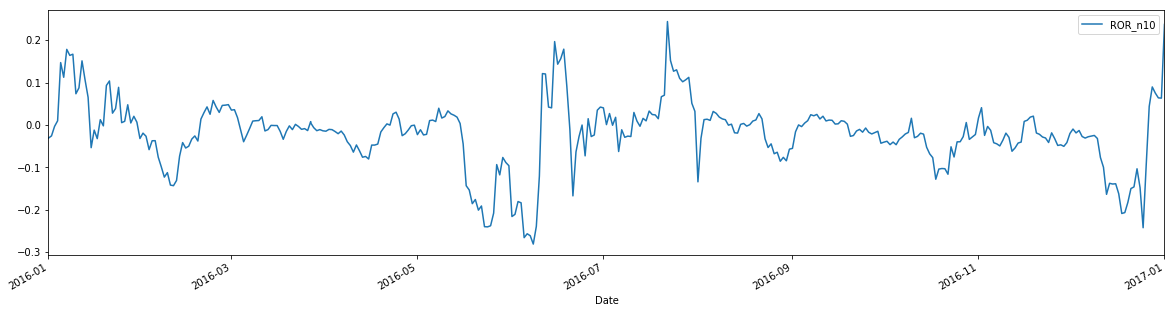

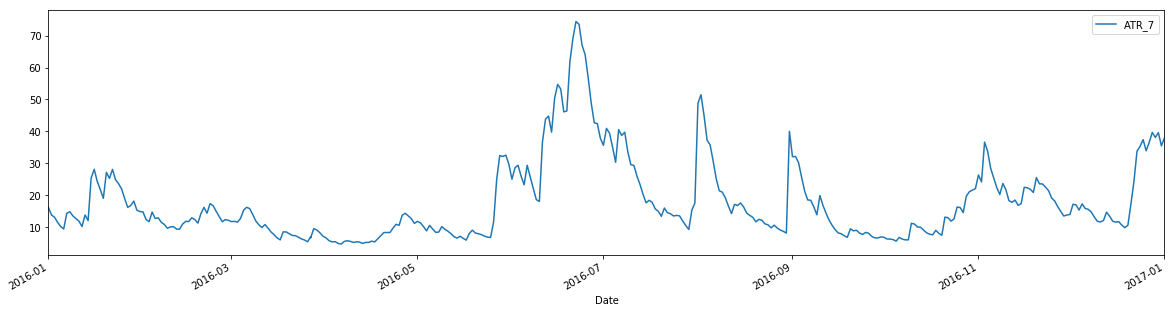

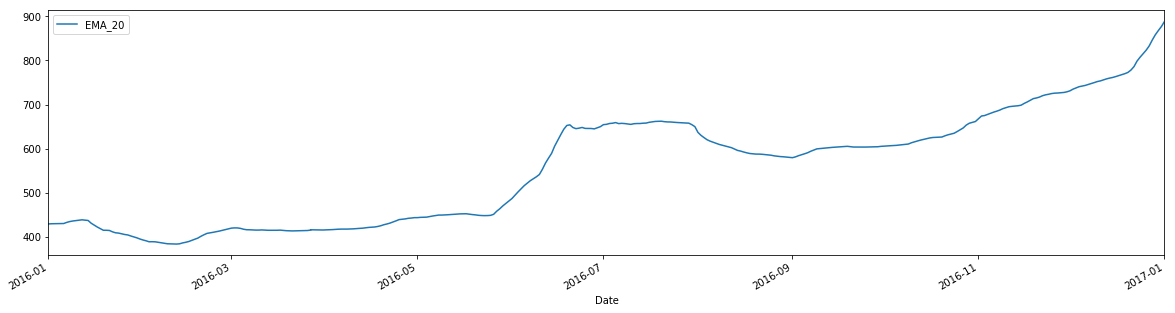

In [18]:
start_date = '2016-01-01'
end_date = '2017-01-01'
%matplotlib inline 

from data_mgmt import data_mgmt as dm

dm.plot_features(df = model.df, x = 'Date', y = 'ROR_n10',
    start_date=start_date, end_date=end_date)

dm.plot_features(df = model.df, x = 'Date', y = 'ATR_7',
    start_date=start_date, end_date=end_date, chart_type = 'line')

dm.plot_features(df = model.df, x = 'Date', y = 'EMA_20',
    start_date=start_date, end_date=end_date, chart_type='line')

